# Self-supervised deblending by denoising

**Authors: Nick Luiken, Matteo Ravasi - KAUST**

In this notebook, we perform deblending by denoising using the newly developed blind-spot network (leveraging its ability to be blind with respect to coherent noise - in this specific case, along the time axis of our seismic pseudo-deblended data).

The denoising problem is casted as follows:

$$
\min_{\theta} \Vert ||f_\theta(d_{pd}) - d_{pd}||_1
$$

where both the *inputs* and *labels* of the network are the pseudo-deblended seismic data $d_{pd}=B^Hd_b$ and $f_\theta$ is our blind-spot denoiser.

The results obtained in this notebook are suboptimal and they serve as benchmark to our proposed *PnP deblending with a self-supervised denoiser* algorithm to showcase the importance of the PnP iterations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import segyio
import pylops

from torch.utils.data import TensorDataset, DataLoader
from ssdeblend.pnp import Blending
from ssdeblend.model.ssstructdenoise import NoiseNetwork
from ssdeblend.model.utils import flip
from ssdeblend.pnp import train
from ssdeblend.utils import set_seed

Let's set the device to use our GPU of choice

In [2]:
torch.cuda.empty_cache()

device = 'cuda:0'
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3090


## Data loading

To begin with, let's load the MobilAVO dataset. This data is stored in a commonly used format in geophysics, called [SEG-Y](https://en.wikipedia.org/wiki/SEG-Y). We are going to use the `segyio` library to do all the heavy lifting for us. 

As the data is stored in contiguous traces, we will rely on data analysis performed outside of this notebook to  arranged the dataset as a three dimensional tensor (or a cube), having the dimensions of the number of sources $n_s$, number of receivers $n_r$, and number of time samples $n_t$: $d_c(x_s, x_r, t)$.

In [3]:
# Load data
f = segyio.open('../data/MobilAVO.segy', ignore_geometry=True)
data = segyio.collect(f.trace[:])
data = data.reshape(1001, 120, 1500)

# Rearrange data
ns = 64 # number of sources
nr = 120 # number of receivers
nt = 1024 # number of time samples
dt = 0.004 # time sampling (sec)
dr = 25 # receiver sampling (m)
data = data[:ns, :, :nt]

# Define axes
t = dt * np.arange(nt)
xr = np.arange(0, nr*dr, dr)

At this point we design our blending strategy: $t_i=i \cdot T + \Delta t_i$. More precisely, we choose an overlap of 50% ($T=T_c/2$ where $T_c$ is the total time lenght of the unblended data) and a random dithering sampled from  $\Delta t_i \sim [-1, 1]$ seconds.

A matrix-free blending operator $B$ is then created using the PyLops[https://pylops.readthedocs.io/en/stable/] library.

In [4]:
# Create blending times
set_seed(42) # we set here the seed for reproducibility
overlap = 0.5
ignition_times = -1 + 2*np.random.rand(ns)
ignition_times[0] = 0 # set the first time dither to 0

# Blending operator
BlendingOp = Blending(nt, nr, ns, dt, overlap, ignition_times, nproc=1)

In [5]:
print('Ignition times:', ignition_times)

Ignition times: [ 0.          0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.88383278  0.73235229  0.20223002  0.41614516 -0.95883101  0.9398197
  0.66488528 -0.57532178 -0.63635007 -0.63319098 -0.39151551  0.04951286
 -0.13610996 -0.41754172  0.22370579 -0.72101228 -0.4157107  -0.26727631
 -0.08786003  0.57035192 -0.60065244  0.02846888  0.18482914 -0.90709917
  0.2150897  -0.65895175 -0.86989681  0.89777107  0.93126407  0.6167947
 -0.39077246 -0.80465577  0.36846605 -0.11969501 -0.75592353 -0.00964618
 -0.93122296  0.8186408  -0.48244004  0.32504457 -0.37657785  0.04013604
  0.09342056 -0.63029109  0.93916926  0.55026565  0.87899788  0.7896547
  0.19579996  0.84374847 -0.823015   -0.60803428 -0.90954542 -0.34933934
 -0.22264542 -0.45730194  0.65747502 -0.28649335]


We are now ready to blend our data ($d_b = B d_c$) and apply pseudo deblending to it ($d_{pd} = B^H d_b$)

In [6]:
blended_data = BlendingOp * data.ravel()
pseudodeblended_data = BlendingOp.H * blended_data

pseudodeblended_data = pseudodeblended_data.reshape(ns, nr, nt)
pseudodeblended_data_rearranged = np.transpose(pseudodeblended_data, (1, 0, 2)) # (nr, ns, nt)

Let's display one original shot gather and its corresponding pseudo deblended gather. This will give us an idea of the interference that we want to suppress.

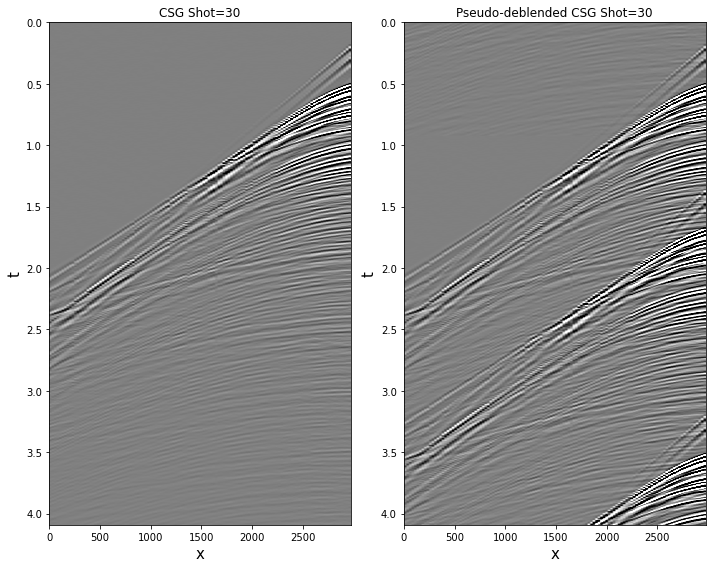

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[0].set_xlabel('x',fontsize=15)
axs[0].set_ylabel('t',fontsize=15)
axs[0].set_title('CSG Shot=30')
axs[1].imshow(pseudodeblended_data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[1].set_xlabel('x',fontsize=15)
axs[1].set_ylabel('t',fontsize=15)
axs[1].set_title('Pseudo-deblended CSG Shot=30')
plt.tight_layout()

Clearly this is not a easy task. Luckily for us, because of the dithering we have added to the blending sequence, the interference will look much less coherent if we slice the pseudo-deblended data over the receiver axis.

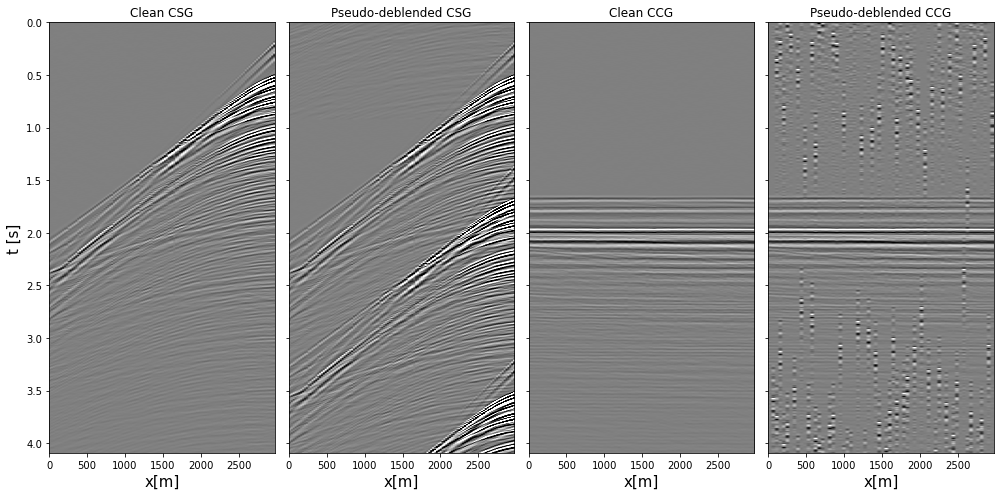

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(14, 7), sharey=True)
axs[0].imshow(data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[0].set_xlabel('x[m]',fontsize=15)
axs[0].set_ylabel('t [s]',fontsize=15)
axs[0].set_title('Clean CSG')
axs[1].imshow(pseudodeblended_data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[1].set_xlabel('x[m]',fontsize=15)
axs[1].set_title('Pseudo-deblended CSG')
axs[2].imshow(data[:, 30, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[2].set_xlabel('x[m]',fontsize=15)
axs[2].set_title('Clean CCG')
axs[3].imshow(pseudodeblended_data[:, 30, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[3].set_xlabel('x[m]',fontsize=15)
axs[3].set_title('Pseudo-deblended CCG')
plt.tight_layout()

## Network rotations

Before we apply deblending by denosing, let's look at the `flip` auxiliary routine that will be applied at the start and at the end of the U-Net architecture to create a flipped version of the inputs CRGs to be used by our structured blind-spot network.

*Note:* due to the design of the network, we prefer here to transpose our CRGs so that time corresponds to the x-axis (i.e., width) and source index corresponds to the y-axis (i.e., height)

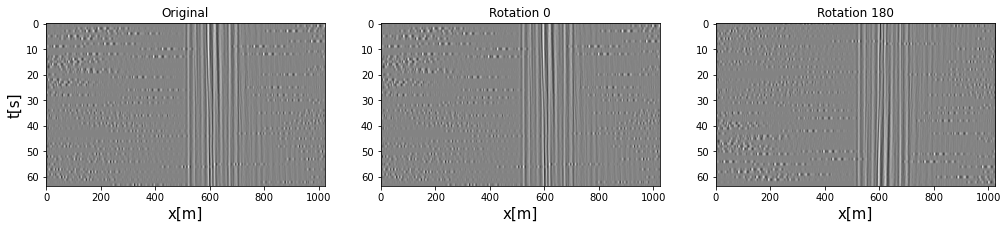

In [9]:
pseudodeblended_crg = torch.from_numpy(pseudodeblended_data_rearranged[0]).float().unsqueeze(0).unsqueeze(0)
rotations = (0, 180)
rotated = [flip(pseudodeblended_crg, rot) for rot in rotations]
rotated = torch.cat((rotated), dim=0)

fig, axs = plt.subplots(1, rotated.shape[0]+1, figsize=(17, 3))
axs[0].imshow(pseudodeblended_crg.cpu().squeeze(), cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Original')
axs[0].set_xlabel('x[m]',fontsize=15)
axs[0].set_ylabel('t[s]',fontsize=15)

for i, (ax, rot) in enumerate(zip(axs[1:], rotations)):
    ax.imshow(rotated[i].cpu().squeeze(), cmap='gray')
    ax.axis('tight')
    ax.set_title(f'Rotation {rot}')
    ax.set_xlabel('x[m]',fontsize=15)

## Deblending by denoising

We are now ready to create our training data 

In [10]:
# Define the training data set
data_set = torch.from_numpy(pseudodeblended_data_rearranged).float()
train_dataset = TensorDataset(data_set, data_set)

# Define dataloader into batches
batch_size = 8
g = torch.Generator()
g.manual_seed(0)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=g)

We can finally create the network and train

In [11]:
set_seed(42)
network = NoiseNetwork(1, 1, blindspot=True).to(device)

In [12]:
criterion = nn.L1Loss()
optimizer = optim.Adam(network.parameters())
epochs = 30   

# train...
for i in range(epochs):
    train_loss = train(network, criterion, optimizer, train_loader, device=device)    
    if i % 2 == 0:
        print(f'Epoch {i}, Training Loss {train_loss:.2f}')

Epoch 0, Training Loss 767.28
Epoch 2, Training Loss 272.15
Epoch 4, Training Loss 257.23
Epoch 6, Training Loss 251.03
Epoch 8, Training Loss 248.02
Epoch 10, Training Loss 245.15
Epoch 12, Training Loss 243.38
Epoch 14, Training Loss 241.36
Epoch 16, Training Loss 240.79
Epoch 18, Training Loss 240.70
Epoch 20, Training Loss 239.34
Epoch 22, Training Loss 238.34
Epoch 24, Training Loss 237.43
Epoch 26, Training Loss 236.86
Epoch 28, Training Loss 236.37


Finally we apply the trained network on every CRG

In [13]:
deblended_data = np.zeros((nr, ns, nt))
for i in range(nr):
    temp = torch.from_numpy(pseudodeblended_data_rearranged[i, :, :])
    temp = network(temp.unsqueeze(0).unsqueeze(0).float().to(device))
    deblended_data[i,  :, :] = temp.cpu().detach().numpy().squeeze()
    
deblended_data = np.transpose(deblended_data, (0, 1, 2))

And we visualize the results for a number of receiver gathers

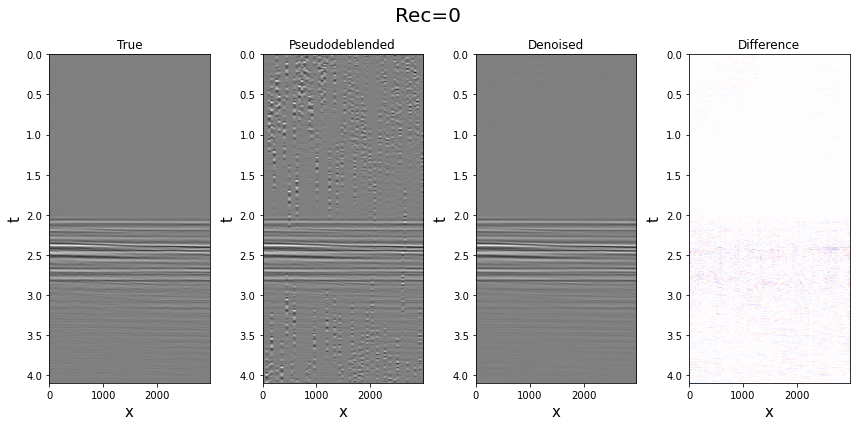

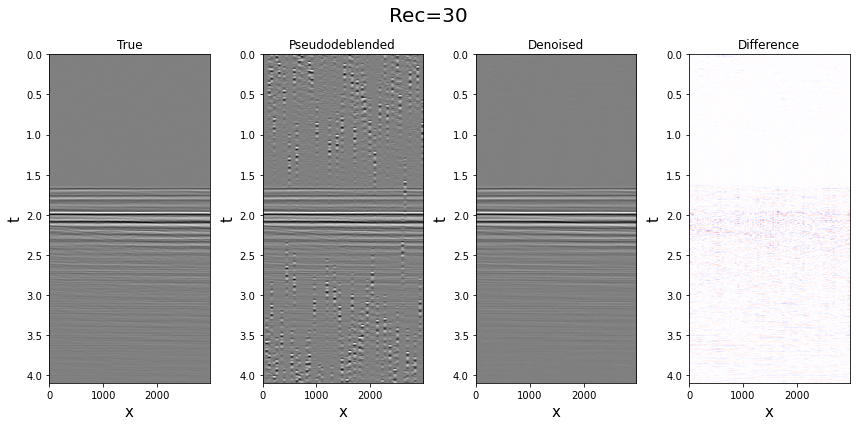

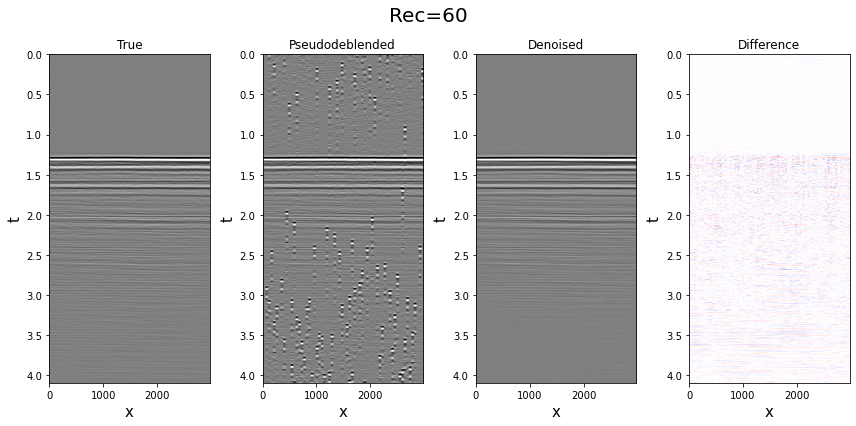

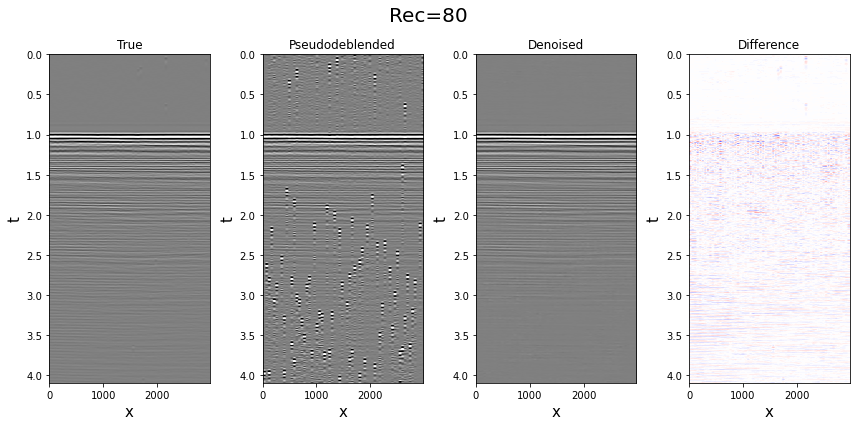

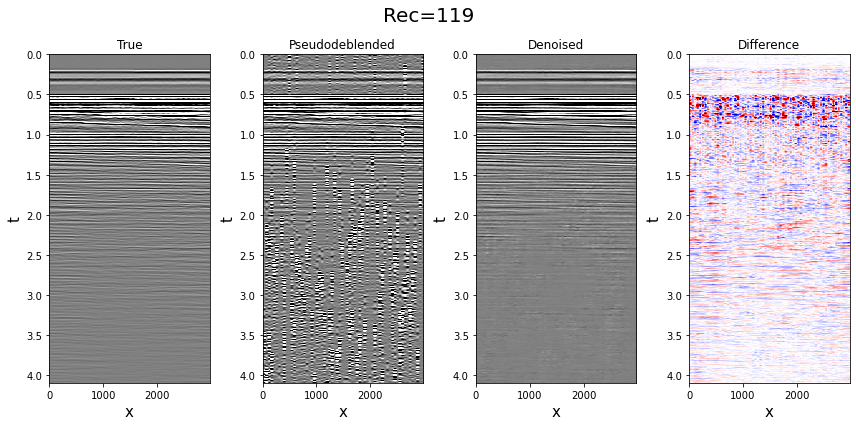

In [14]:
idxs = [0, nr//4, nr//2, 2*nr//3, nr-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Rec={idx}',fontsize=20)
    axs[0].imshow(data[:, idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data_rearranged[idx].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(deblended_data[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Denoised')
    axs[3].imshow((data[:, idx] - deblended_data[idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100, cmap='seismic',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

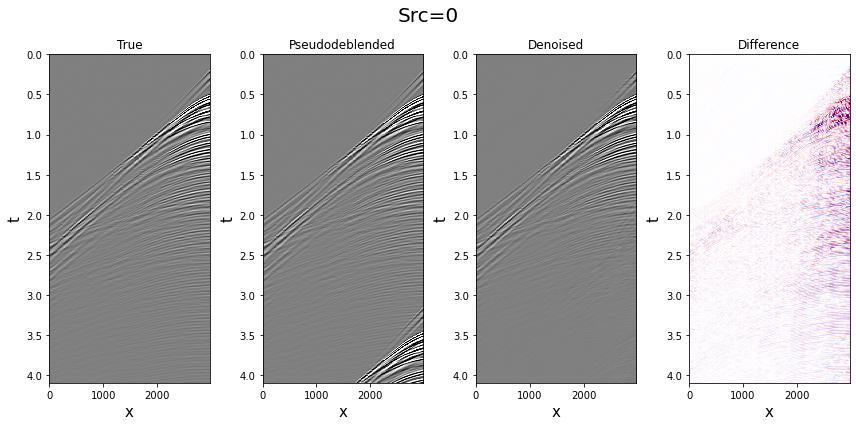

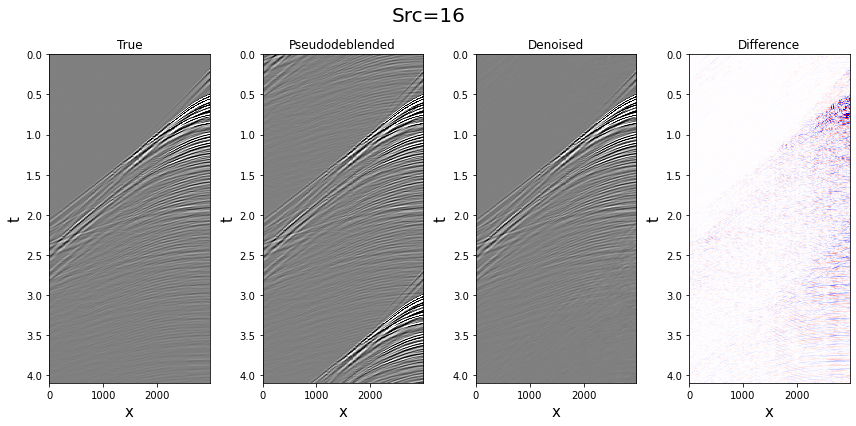

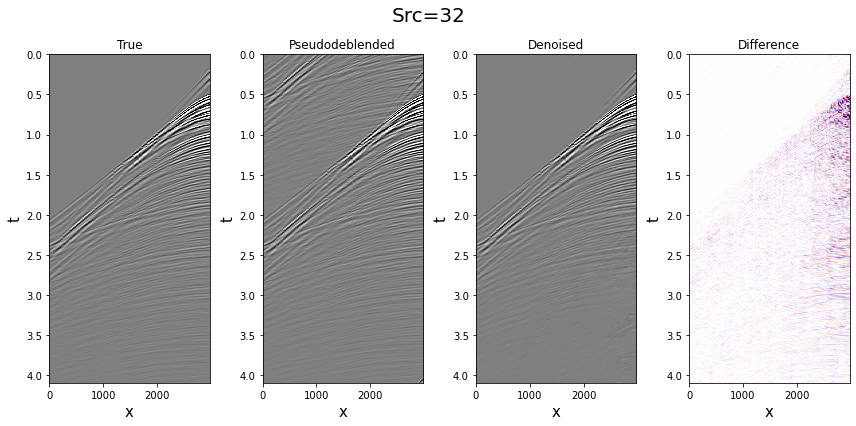

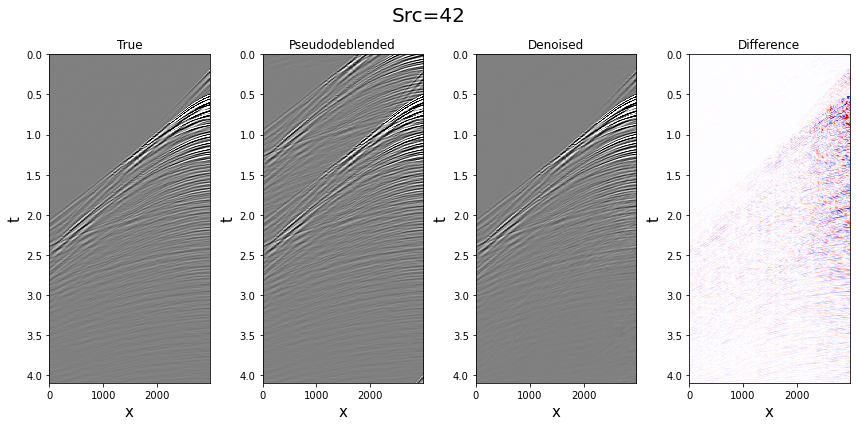

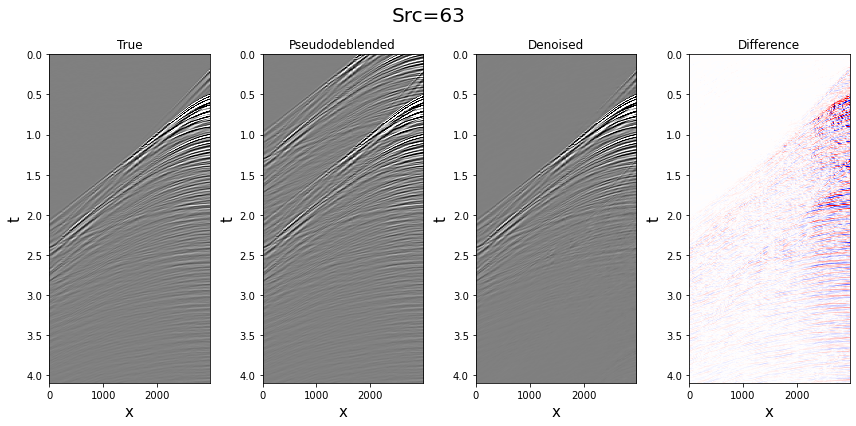

In [15]:
idxs = [0, ns//4, ns//2, 2*ns//3, ns-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Src={idx}',fontsize=20)
    axs[0].imshow(data[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data_rearranged[:, idx].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(deblended_data[:, idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Denoised')
    axs[3].imshow((data[idx] - deblended_data[:, idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100, cmap='seismic',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

Finally we compute the total RMSE of deblending by denoising

In [16]:
error_denoised = np.linalg.norm(deblended_data.transpose(1, 0, 2).ravel() - data.ravel()) / np.linalg.norm(data.ravel())
print(f'Total RMSE:{error_denoised}')

Total RMSE:0.190120019117434
